In [11]:
import numpy as np
import torch
from diffusion.diffusionmodel import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
from diffusion.potential import LinearInterpolation 
from diffusion.utils import load_or_generate_and_then_save

torch.random.manual_seed(199)

device = 'cuda'

In [12]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)


net = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.SiLU(), torch.nn.Linear(64, 1))

In [5]:
# the potential function
V = LinearInterpolation(prior=prior, target=target, net=net)

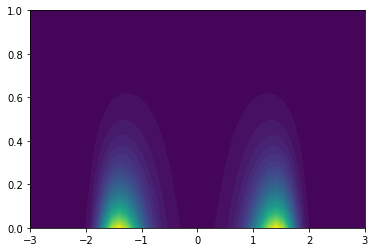

In [6]:
import matplotlib.pyplot as plt

ts = np.linspace(0, 1, 50, dtype=np.float32)
xs = np.linspace(-3, 3, 50, dtype=np.float32)

X, Y = np.meshgrid(xs, ts)

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)
naive_interpol = lambda x, t :  (1 - t) * target.energy(x) + t * prior.energy(x)
naive_out = naive_interpol(X.reshape(50*50, 1), Y.reshape(50*50, 1)).reshape(50, 50)
plt.contourf(X.cpu(), Y.cpu(), torch.exp(-naive_out).cpu(), levels=50)
plt.show()

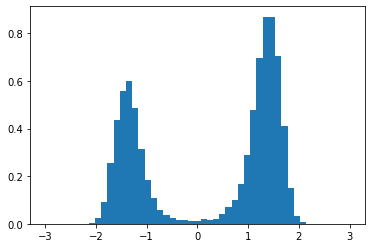

In [7]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))


datafilepath = './data/double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs, density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()


In [10]:
from diffusion import diffusionmodel


def cumulative_beta_linear(t):
    '''The integral of the noise schedule over the interval [0, t]. In this case a simple linear schedule'''
    return t

sde = diffusionmodel.SDE(TransitionKernel(cumulative_beta=cumulative_beta_linear))

NameError: name 'sde' is not defined

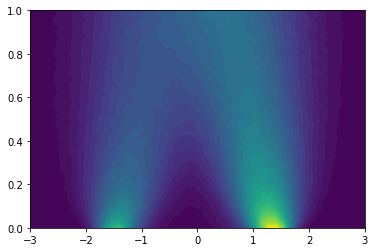

In [7]:
z = np.zeros_like(X)
for i, t in enumerate(ts):
    t_s=torch.full_like(data, t)
    x_t = sde.forward_sample(x_0=data, t=t_s)
    z[i] = np.histogram(x_t, bins=np.append(xs, 6))[0]


plt.contourf(X, Y, z, levels=50)

In [8]:
batch_size = 128

diff_model = DiffusionModel(potential=V, device=device)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
optimizer = Adam(diff_model.parameters(), lr=1e-3)


def MSE_loss(prediction, ground_truth):
    loss = ((prediction - ground_truth)**2).mean()
    return loss


In [9]:
from train import train

train(diff_model, 
      sde=sde,
      loss_fn=MSE_loss, 
      optimizer=optimizer, 
      data_loader=train_loader, 
      n_iterations=10, 
      device=device)

Epoch 0/20 total loss: 7119.664550781256144414
Epoch 1/20 total loss: 6843.579589843750551758
Epoch 2/20 total loss: 6971.213867187597247314
Epoch 3/20 total loss: 6831.833984375590454102
Epoch 4/20 total loss: 6397.677734375044860842
Epoch 5/20 total loss: 6177.837890625816650397
Epoch 6/20 total loss: 5743.251953125020088196
Epoch 7/20 total loss: 6056.959472656251865234
Epoch 8/20 total loss: 5213.492675781256171875
Epoch 9/20 total loss: 5056.569824218757767334
Epoch 10/20 total loss: 5270.71630859375405277
Epoch 11/20 total loss: 4635.64062599428558354
Epoch 12/20 total loss: 4050.316162109375503414
Epoch 13/20 total loss: 3794.51269531254382328
Epoch 14/20 total loss: 3704.05249023437567871
Epoch 15/20 total loss: 3392.96875050864219666
Epoch 16/20 total loss: 3095.43017578125835815
Epoch 17/20 total loss: 2806.79443359375228277
Epoch 18/20 total loss: 2311.28027343754772951
Epoch 19/20 total loss: 2481.516601562596920787


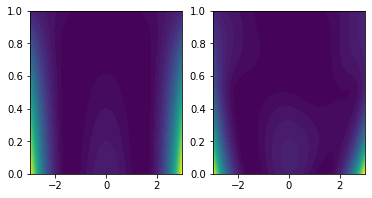

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

X = X.to(device)
Y = Y.to(device)

with torch.no_grad():
    post_training_out = V.energy(X.view(50*50, 1), Y.view(50*50, 1)).view(50,50)


naive_interpolation = lambda x, t :  (1 - t) * target.energy(x) + t * prior.energy(x)
naive_out = naive_interpolation(X.view(50*50, 1), Y.view(50*50, 1)).view(50, 50)
naive_out = naive_out - naive_out.min(dim=1, keepdim=True)[0]

im1 = ax1.contourf(X.cpu(), Y.cpu(), naive_out.cpu(), levels=50)

post_training_out = post_training_out - post_training_out.min(dim=1, keepdim=True)[0]

im2 = ax2.contourf(X.cpu(), Y.cpu(), post_training_out.cpu(), levels=50)